<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%reset -f

### Imports

In [ ]:
!pip install rioxarray
!pip install rasterio
!pip install tifffile
!pip install imagecodecs

In [8]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(1281, 2042, 17)
(1623575, 17)
(1623575,)


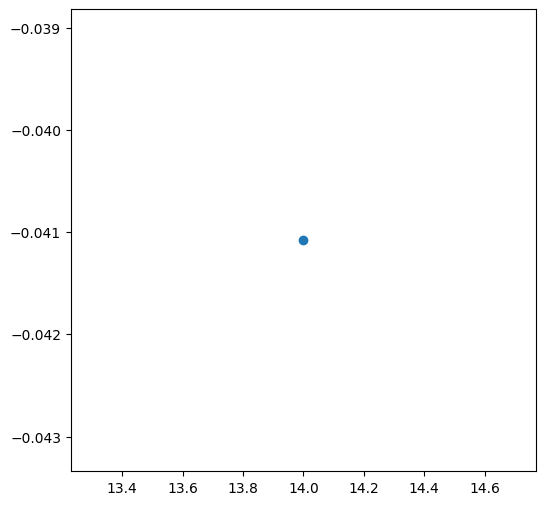

In [11]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

compf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/thing'

image = Image.open('/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = (arr >= 0) & (arr < 16)

img_array = tifffile.imread(compf)
shp = img_array.shape
print(shp)
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
print(X.shape)
test_scores = []

test_cluster_sizes = [14]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'Extract_Compos_ClassifyRaste.crf.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Silhouette score/No breakpoint

(1281, 2042, 17)
(1623575, 17)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)


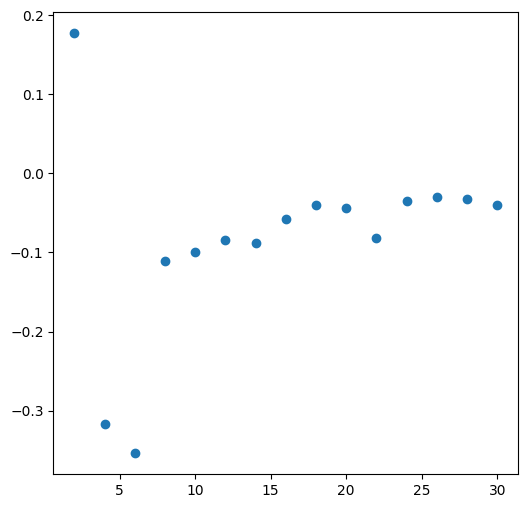

In [5]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

compf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

image = Image.open('/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = (arr > 0) & (arr < 16)

img_array = tifffile.imread(compf)
shp = img_array.shape
print(shp)
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
print(X.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


###Silhouette score/One breakpoint

Optimal breakpoint 1: 6.242424242424242


/tmp/ipython-input-2686950674.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


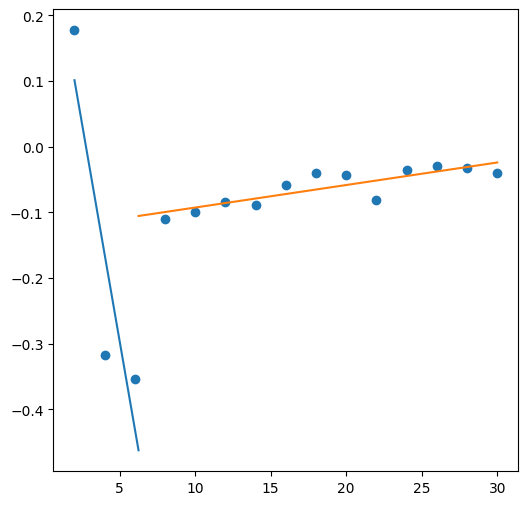

In [6]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Davies-Bouldin score/No breakpoint

(1281, 2042, 17)
(1623575, 17)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)
(1623575,)


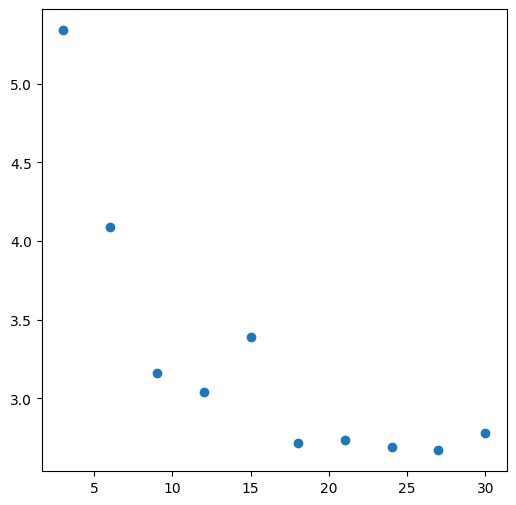

In [12]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

compf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

image = Image.open('/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = (arr > 0) & (arr < 16)

img_array = tifffile.imread(compf)
shp = img_array.shape
print(shp)
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
print(X.shape)

test_scores = []
test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)

  score = davies_bouldin_score(X, cluster_labels)
  test_scores.append(score)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


###Davies-Bouldin score/One breakpoint

Optimal breakpoint 1: 6.2727272727272725


/tmp/ipython-input-3575090378.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


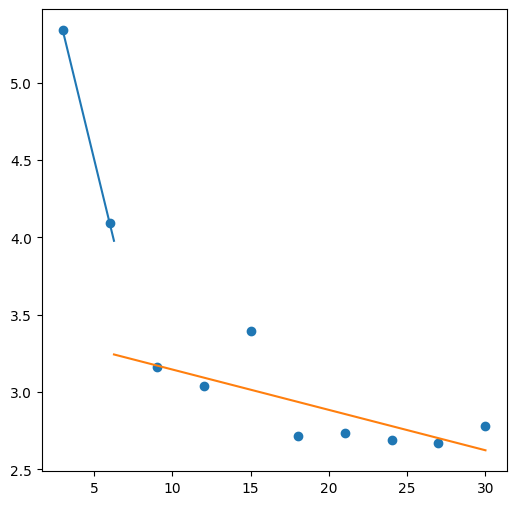

In [13]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Purity score/No breakpoint

['Zonal_eco3_3.csv', 'Zonal_eco3_9.csv', 'Zonal_eco3_15.csv', 'Zonal_eco3_21.csv', 'Zonal_eco3_27.csv', 'Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,291599,36470,738,1797,105710,716,148958,4066,34378,0,349,0,1347,12789,15488
1,2,3421,37215,0,110,2397,28,17567,42482,64491,45661,90138,0,47059,0,109311
2,3,150026,2736,3797,63932,40473,38911,31529,109406,1295,60,10728,1398,5858,48970,39


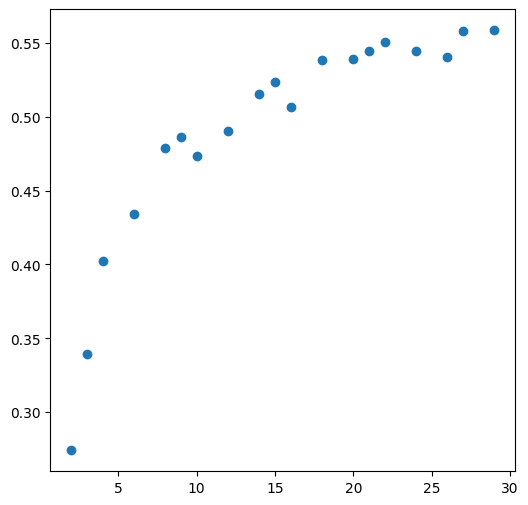

In [14]:

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_dict = {}
for key in keys:
  sorted_dict[key] = df_dict[key]

purity_list = []
for key in sorted_dict:
  df = sorted_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  purity_list.append(purity)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, purity_list)



###Purity score/One breakpoint

Optimal breakpoint 1: 4.181818181818182


/tmp/ipython-input-238521905.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


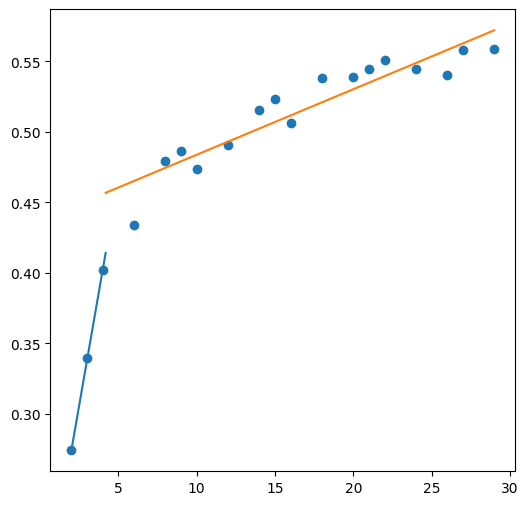

In [15]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in purity_list])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



###Entropy score/No breakpoint

,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,291599,36470,738,1797,105710,716,148958,4066,34378,0,349,0,1347,12789,15488
1,2,3421,37215,0,110,2397,28,17567,42482,64491,45661,90138,0,47059,0,109311
2,3,150026,2736,3797,63932,40473,38911,31529,109406,1295,60,10728,1398,5858,48970,39


/tmp/ipython-input-1822058004.py:32: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-1822058004.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


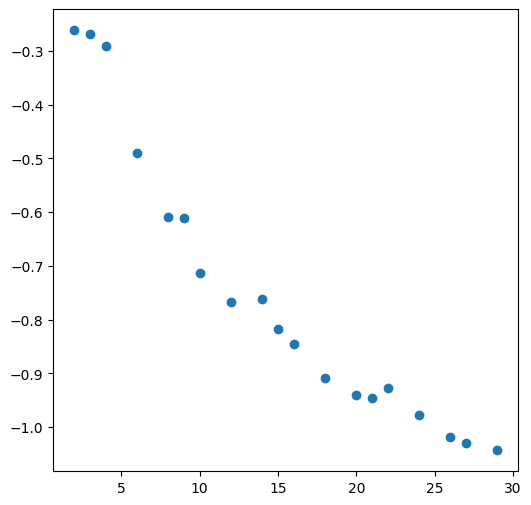

In [16]:
fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_dict = {}
for key in keys:
  sorted_dict[key] = df_dict[key]

entropy_list = []
for key in sorted_dict:
  sorted_dict[key] = df_dict[key]
  df = sorted_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  entropy_list.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, entropy_list)


###Entropy score/One breakpoint

Optimal breakpoint 1: 10.181818181818182


/tmp/ipython-input-3818795856.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


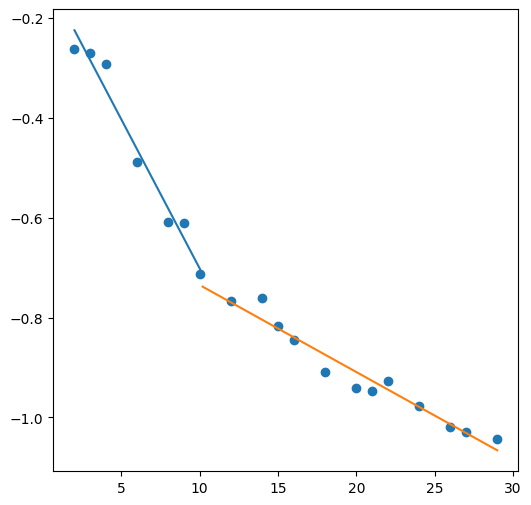

In [17]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in entropy_list])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])

